In [1]:
import sys
sys.path.insert(0, '..')

from intransparent import (
    REPORTS_PER_PLATFORM,
    ingest_reports_per_platform,
    long_ncmec_reports,
    wide_ncmec_reports,
    compare_all_platform_reports,
    show,
)

show('<h1>CSAM Reports per Platform</h1>')
show('<h2>Ingesting Platform Disclosures</h2>')

def logger(format: str, *args, **kwargs) -> None:
    print(format.format(*args, **kwargs))

data = ingest_reports_per_platform(REPORTS_PER_PLATFORM, logger=logger)

show('<h2>An Overview of Platform Disclosures</h2>')
show(data.features, caption='Platforms and Their Disclosures')

Skipping metadata
❌ Alphabet (no CSAM data)
❌ Automattic (no CSAM data)
✅ Discord
✅ Facebook
✅ Google
✅ Instagram
✅ LinkedIn
❌ Meta (no CSAM data)
✅ Microsoft
❌ Omegle (no CSAM data)
✅ Pinterest
❌ Quora (no CSAM data)
✅ Reddit
✅ Snap
❌ Telegram (no transparency disclosures)
✅ TikTok
✅ TikTok (original schema)
❌ Tumblr (no CSAM data)
✅ Twitch
✅ Twitter
❌ WhatsApp (no CSAM data)
❌ Wordpress (no CSAM data)
❌ X (no CSAM data)
✅ YouTube
✅ NCMEC


,data,history,terms,quantities,granularity,frequency,coverage,has_reports
platform,,,,,,,,
Alphabet,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Automattic,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Discord,csv,same page (dropdown),child safety; CSAM,counts,Q,Q,2020 H2,True
Facebook,csv,data,child nudity & sexual exploitation; child sexual exploitation,rounded,Q,Q,2018 Q3,False
Google,⋯,same page (dropdown),CSAM,counts,H,H,2020 H1,True
Instagram,csv,data,child nudity & sexual exploitation; sexual exploitation,rounded,Q,Q,2019 Q2,False
LinkedIn,⋯,same page (tabs),child exploitation,counts,H,H,2019 H1,False
Meta,⋯,⋯,⋯,⋯,⋯,⋯,⋯,⋯
Microsoft,xls,same page (dropdown),CSAM,counts,H,H,2020 H1,True


In [2]:
show('<h2>Ranking of Social Media Firms</h2>')

ncmec = long_ncmec_reports(data)
totals = ncmec[ncmec['platform'] == 'Total']['reports']

year = ncmec.index.min()
stop = ncmec.index.max()

while year <= stop:
    yearly = (
        ncmec.loc[year]
        .sort_values('reports', ascending=False)
        .assign(reports_pct=lambda df: df['reports'] / totals[year] * 100)
    )

    yearly.loc[yearly['platform'].isin(['ESP Total', 'Total']), 'reports_pct'] = None
    yearly['cumpct'] = yearly['reports_pct'].cumsum()

    show(
        yearly,
        caption=f' Social Media by CSAM Reports Filed in {year}',
    )
    year += 1

,platform,reports,reports_pct,cumpct
period,,,,
2019,Total,"16,987,361",⋯,⋯
2019,ESP Total,"16,836,694",⋯,⋯
2019,Meta,"15,884,511",93.50782031,93.5
2019,Alphabet,"449,283",2.64480751,96.2
2019,Microsoft,"123,927",0.72952473,96.9
2019,Snap,"82,030",0.48288843,97.4
2019,X,"45,726",0.26917660,97.6
2019,Discord,"19,480",0.11467349,97.7
2019,Automattic,"10,443",0.06147512,97.8


,platform,reports,reports_pct,cumpct
period,,,,
2020,Total,"21,751,085",⋯,⋯
2020,ESP Total,"21,447,786",⋯,⋯
2020,Meta,"20,307,216",93.36185298,93.4
2020,Alphabet,"546,704",2.51345623,95.9
2020,Snap,"144,095",0.66247270,96.5
2020,Microsoft,"96,836",0.44520078,97.0
2020,X,"65,062",0.29912071,97.3
2020,TikTok,"22,692",0.10432583,97.4
2020,Omegle,"20,265",0.09316777,97.5


,platform,reports,reports_pct,cumpct
period,,,,
2021,Total,"29,397,681",⋯,⋯
2021,ESP Total,"29,157,083",⋯,⋯
2021,Meta,"26,885,302",91.4538191,91.5
2021,Alphabet,"875,783",2.9790887,94.4
2021,Snap,"512,522",1.7434096,96.2
2021,TikTok,"154,618",0.5259531,96.7
2021,X,"86,666",0.2948056,97.0
2021,Microsoft,"78,883",0.2683307,97.3
2021,Omegle,"46,924",0.1596180,97.4


,platform,reports,reports_pct,cumpct
period,,,,
2022,Total,"32,059,029",⋯,⋯
2022,ESP Total,"31,802,525",⋯,⋯
2022,Meta,"27,190,665",84.81437,84.8
2022,Alphabet,"2,174,548",6.78295,91.6
2022,Omegle,"608,601",1.89838,93.5
2022,Snap,"551,086",1.71897,95.2
2022,TikTok,"288,125",0.89873,96.1
2022,Discord,"169,800",0.52965,96.6
2022,Microsoft,"108,798",0.33937,97.0


,platform,reports,reports_pct,cumpct
period,,,,
2023,Total,"36,210,368",⋯,⋯
2023,ESP Total,"35,944,826",⋯,⋯
2023,Meta,"30,658,047",84.6665,84.7
2023,Alphabet,"1,470,958",4.0623,88.7
2023,X,"870,503",2.4040,91.1
2023,Snap,"713,055",1.9692,93.1
2023,TikTok,"590,376",1.6304,94.7
2023,Discord,"339,412",0.9373,95.7
2023,Reddit,"290,141",0.8013,96.5


In [3]:
show('<h2>Transparency Data Quality per Social Medium</h2>')

# No piece counts are available for the rest of Microsoft in 2019.
# So we drop LinkedIn's data, which is in the noise already.
linkedin = data.disclosures["LinkedIn"]
linkedin.loc[linkedin.index.year == 2019, "pieces"] = None

comparisons = compare_all_platform_reports(data)

brand_holders = len(data.brands)
brand_holder_brands = sum(len(brands) for brands in data.brands.values())
# Account for '@' and 'NCMEC':
surveyed_brands = len(REPORTS_PER_PLATFORM) - 1 - 1 - brand_holders
surveyed_firms = surveyed_brands - brand_holder_brands + brand_holders
# Account for 'NCMEC':
brands_with_disclosures = len(set(data.disclosures) - set(data.brands)) - 1

show(
    f"""
    Out of {surveyed_brands} surveyed social media platforms owned by
    {surveyed_firms} firms, {brands_with_disclosures} brands make transparency
    disclosures. Furthermore, only {len(comparisons)} platforms disclose usable
    piece or report counts.
    """
)

show("<strong><em>Only Discord and Meta have complete rows for 2023!</em></strong>")

for platform, table in comparisons.items():
    show(table, caption=platform, min_precision=3)

,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"449,283",2.668,"16,836,694",2.645,"16,987,361",99.113
2020,"4,437,853",8.100,"547,875",-0.2137,"546,704",2.549,"21,447,786",2.513,"21,751,085",98.606
2021,"6,696,497",7.694,"870,319",0.6278,"875,783",3.004,"29,157,083",2.979,"29,397,681",99.182
2022,"13,402,885",6.164,"2,174,319",0.0105,"2,174,548",6.838,"31,802,525",6.783,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"1,470,958",4.092,"35,944,826",4.062,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"10,443",0.0620,"16,836,694",0.0615,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"9,130",0.0426,"21,447,786",0.0420,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"4,821",0.0165,"29,157,083",0.0164,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"5,035",0.0158,"31,802,525",0.0157,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"19,591",0.0545,"35,944,826",0.0541,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"19,480",0.1157,"16,836,694",0.1147,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"15,324",0.0714,"21,447,786",0.0705,"21,751,085",98.606
2021,⋯,⋯,"24,623",20.237,"29,606",0.1015,"29,157,083",0.1007,"29,397,681",99.182
2022,⋯,⋯,"58,179",191.858,"169,800",0.5339,"31,802,525",0.5296,"32,059,029",99.200
2023,⋯,⋯,"164,478",106.357,"339,412",0.9443,"35,944,826",0.9373,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,"39,368,400",2.478,⋯,⋯,"15,884,511",94.345,"16,836,694",93.508,"16,987,361",99.113
2020,"38,890,800",1.915,⋯,⋯,"20,307,216",94.682,"21,447,786",93.362,"21,751,085",98.606
2021,"78,012,400",2.902,⋯,⋯,"26,885,302",92.208,"29,157,083",91.454,"29,397,681",99.182
2022,"105,800,000",3.891,⋯,⋯,"27,190,665",85.498,"31,802,525",84.814,"32,059,029",99.200
2023,"63,300,000",2.065,⋯,⋯,"30,658,047",85.292,"35,944,826",84.666,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"123,927",0.736,"16,836,694",0.730,"16,987,361",99.113
2020,"1,256,855",13.033,"96,435",0.4158,"96,836",0.451,"21,447,786",0.445,"21,751,085",98.606
2021,"564,609",7.154,"78,926",-0.0545,"78,883",0.271,"29,157,083",0.268,"29,397,681",99.182
2022,"454,321",4.222,"107,599",1.1143,"108,798",0.342,"31,802,525",0.339,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"141,236",0.393,"35,944,826",0.390,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"3,470",0.0206,"16,836,694",0.0204,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"20,265",0.0945,"21,447,786",0.0932,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"46,924",0.1609,"29,157,083",0.1596,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"608,601",1.9137,"31,802,525",1.8984,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"188,102",0.5233,"35,944,826",0.5195,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"7,360",0.04371,"16,836,694",0.04333,"16,987,361",99.113
2020,⋯,⋯,"3,432",≡,"3,432",0.01600,"21,447,786",0.01578,"21,751,085",98.606
2021,"1,608",0.599,"2,684",-14.940,"2,283",0.00783,"29,157,083",0.00777,"29,397,681",99.182
2022,"37,136",1.127,"32,964",4.083,"34,310",0.10788,"31,802,525",0.10702,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"52,356",0.14566,"35,944,826",0.14459,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,1,0.00000594,"16,836,694",0.00000589,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,2,0.00000932,"21,447,786",0.00000919,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,25,0.00008574,"29,157,083",0.00008504,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"2,242",0.00704975,"31,802,525",0.00699335,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"6,135",0.01706783,"35,944,826",0.01694266,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,724,≡,724,0.00430,"16,836,694",0.00426,"16,987,361",99.113
2020,⋯,⋯,"2,233",≡,"2,233",0.01041,"21,447,786",0.01027,"21,751,085",98.606
2021,"9,258",0.920,"10,059",≡,"10,059",0.03450,"29,157,083",0.03422,"29,397,681",99.182
2022,"80,888",1.538,"52,592",≡,"52,592",0.16537,"31,802,525",0.16405,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"290,141",0.80718,"35,944,826",0.80126,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"82,030",0.487,"16,836,694",0.483,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"144,095",0.672,"21,447,786",0.662,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"512,522",1.758,"29,157,083",1.743,"29,397,681",99.182
2022,"1,273,838",2.313,"550,755",0.0601,"551,086",1.733,"31,802,525",1.719,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"713,055",1.984,"35,944,826",1.969,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,596,0.00354,"16,836,694",0.00351,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"22,692",0.10580,"21,447,786",0.10433,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"154,618",0.53029,"29,157,083",0.52595,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"288,125",0.90598,"31,802,525",0.89873,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"590,376",1.64245,"35,944,826",1.63041,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,541,0.00321,"16,836,694",0.00318,"16,987,361",99.113
2020,⋯,⋯,"2,158",⋯,⋯,0.01006,"21,447,786",0.00992,"21,751,085",98.606
2021,⋯,⋯,"6,621",0.121,"6,629",0.02274,"29,157,083",0.02255,"29,397,681",99.182
2022,⋯,⋯,"14,296",1.483,"14,508",0.04562,"31,802,525",0.04525,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"6,665",0.01854,"35,944,826",0.01841,"36,210,368",99.267


,pieces,π,reports,Δ%,NCMEC,esp%,esp,total%,total,esp/total%
period,,,,,,,,,,
2019,⋯,⋯,⋯,⋯,"45,726",0.272,"16,836,694",0.269,"16,987,361",99.113
2020,⋯,⋯,⋯,⋯,"65,062",0.303,"21,447,786",0.299,"21,751,085",98.606
2021,⋯,⋯,⋯,⋯,"86,666",0.297,"29,157,083",0.295,"29,397,681",99.182
2022,⋯,⋯,⋯,⋯,"98,050",0.308,"31,802,525",0.306,"32,059,029",99.200
2023,⋯,⋯,⋯,⋯,"870,503",2.422,"35,944,826",2.404,"36,210,368",99.267


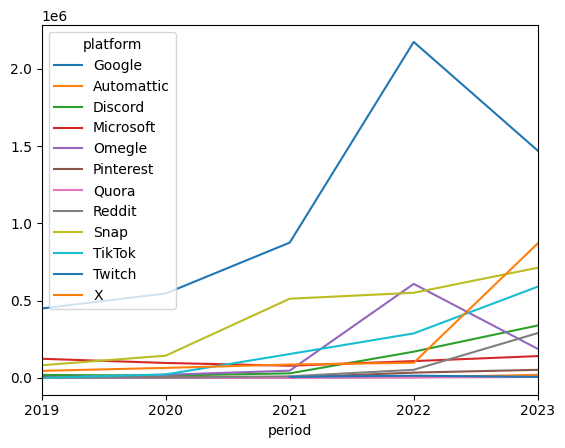

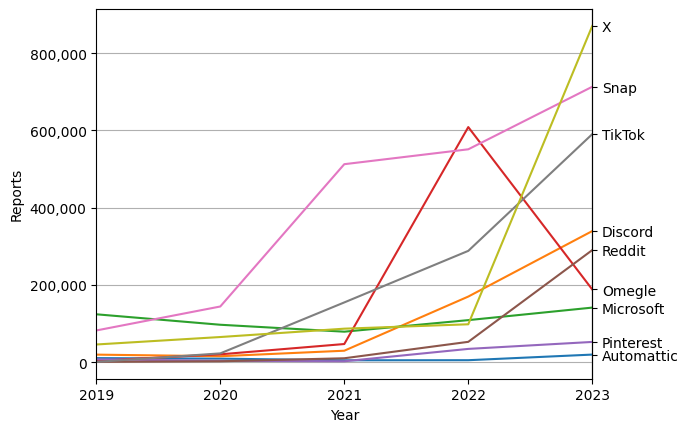

In [4]:
import matplotlib as mp

ncmec = (
    wide_ncmec_reports(data)
    .drop(columns=["Meta", "Telegram", "ESP Total", "Total"])
    .rename(columns={"Alphabet": "Google"})
)

ncmec.plot()

ncmec = ncmec.drop(columns=["Google", "Twitch", "Quora"])
ax = ncmec.plot()

ax.legend().remove()

ax.set_xlabel("Year")

ax.get_yaxis().set_major_formatter(
    mp.ticker.FuncFormatter(lambda x, _: format(int(x), ","))
)
ax.set_ylabel("Reports")
ax.grid(axis="y")

platforms = [
    "Automattic", "Pinterest", "Microsoft", "Omegle",
    "Reddit", "Discord", "TikTok", "Snap", "X"
]
positions = [ncmec.loc["2023", p] for p in platforms]

alt = ax.secondary_yaxis(location="right")
alt.set_yticks(positions, labels=platforms)
ax.figure.savefig("../figure/etc-reports-per-year.svg", bbox_inches='tight')
